# Analyse des types de SST et clustering

**Objectif :** Analyser les différents types de sous-stations (SST) qui composent le réseau et les regrouper en clusters pour une meilleure compréhension et exploitation.

**Données sources :**
- **CAD** : `0_Data/0_Raw/RefFiles/Point_transmission_CAD_20260202.xlsx` — toutes les sous-stations CAD du réseau
- **Mesures archivées** : `0_Data/1_Structured/sst_unified.parquet` — DF avec colonnes `{U_NO_EGID}_TempRet` et `{U_NO_EGID}_PuisCpt`

**Colonnes analysées :**
- `U_TYPE_REGUL` : type de régulation
- `U_PROD_ECS` : production ECS (eau chaude sanitaire)
- `U_PUISSANCE` : puissance nominale (kW)

In [2]:
# %% Imports et configuration
import re
from pathlib import Path
import sys
print(sys.executable)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Chemins relatifs au dossier 2_Program
PATH_CAD = Path("0_Data/0_Raw/RefFiles/Point_transmission_CAD_20260202.xlsx")
PATH_PARQUET = Path("0_Data/1_Structured/sst_unified.parquet")

# Style des graphiques
try:
    plt.style.use("seaborn-v0_8-whitegrid")
except OSError:
    plt.style.use("seaborn-whitegrid")
sns.set_palette("husl")

c:\LUA\CASIA\TCas\2_Program\.venv\Scripts\python.exe


## 1. Chargement des données

- Charger le fichier Excel CAD
- Charger le parquet et extraire les EGIDs des colonnes (format `{EGID}_TempRet` ou `{EGID}_PuisCpt`)
- Filtrer le CAD pour ne garder que les SST ayant des mesures archivées

In [3]:
# %% Chargement CAD
df_cad = pd.read_excel(PATH_CAD, sheet_name=0)
print(f"CAD : {len(df_cad)} sous-stations, {len(df_cad.columns)} colonnes")
print("Colonnes clés : U_NO_EGID, U_TYPE_REGUL, U_PROD_ECS, U_PUISSANCE")
df_cad.head(3)

CAD : 1245 sous-stations, 83 colonnes
Colonnes clés : U_NO_EGID, U_TYPE_REGUL, U_PROD_ECS, U_PUISSANCE


,OBJECTID,NAME_NUMMER,ART,LEISTUNG_ABONNIERT,LEISTUNG_INSTALLIERT,BLENDENWERT,Q_ABONNIERT,KATEGORIE,DRUCK,VORLAUFTEMPERATUR,...,GN_CREATED_DATE,GN_CREATED_USER,GN_LAST_EDITED_DATE,GN_LAST_EDITED_USER,INBETRIEBSETZUNG,UMBAU,BAUJAHR,ILI_OPERAT,ILI_CLASS,ILI_XTF_ID
0,1,945073,Station de branchement d'immeuble,NaN,NaN,1.0,0.201,En service,NaN,95.0,...,16.07.2009,LIDS,27.01.2025 14:33,SEGUILBA,NaN,NaN,2009,NaN,NaN,NaN
1,2,945057,Station de branchement d'immeuble,NaN,NaN,1.0,0.201,En service,NaN,95.0,...,16.07.2009,LIDS,14.03.2022 13:45,MPGROSSR,NaN,NaN,2009,NaN,NaN,NaN
2,5,945069,Station de branchement d'immeuble,NaN,NaN,1.0,0.201,En service,NaN,95.0,...,16.07.2009,LIDS,13.03.2025 14:37,SEGUILBA,NaN,NaN,2009,NaN,NaN,NaN


In [4]:
# %% Extraction des EGIDs du parquet (SST avec mesures archivées)
df_parquet = pd.read_parquet(PATH_PARQUET)
cols_measures = [c for c in df_parquet.columns if c not in ["timestamp_loc", "temp_ext_api"]]

egids_parquet = set()
for col in cols_measures:
    parts = col.split("_")
    if len(parts) >= 2 and parts[0].isdigit():
        egids_parquet.add(int(parts[0]))

print(f"Parquet : {len(df_parquet)} lignes, {len(egids_parquet)} SST avec mesures archivées")
print(f"Exemple EGIDs : {sorted(egids_parquet)[:10]}")

Parquet : 169486 lignes, 369 SST avec mesures archivées
Exemple EGIDs : [1510482, 1510532, 1510539, 1510544, 1510546, 1510547, 1510557, 1510558, 1510563, 1510566]


In [5]:
# %% Fusion : filtrer CAD sur les SST avec mesures
df_cad["U_NO_EGID_num"] = pd.to_numeric(df_cad["U_NO_EGID"], errors="coerce")
df_sst = df_cad[df_cad["U_NO_EGID_num"].isin(egids_parquet)].copy()
df_sst = df_sst.drop(columns=["U_NO_EGID_num"])

print(f"SST analysées (CAD + mesures) : {len(df_sst)}")
df_sst[["U_NO_EGID", "U_TYPE_REGUL", "U_PROD_ECS", "U_PUISSANCE"]].head(10)

SST analysées (CAD + mesures) : 369


,U_NO_EGID,U_TYPE_REGUL,U_PROD_ECS,U_PUISSANCE
99,1511115,SST30_V1,1.0,40kW
131,235554367,SST30_V1,0.0,10kW
158,190207613,SST30_V0,0.0,22kW
166,235557440,SST30_V1,1.0,9kW
167,235557446,SST30_V1,1.0,9kW
168,235557447,SST30_V1,1.0,9kW
170,190199608,SST30_V1,0.0,10kW
210,1511720,SST30_V3,0.0,160kW
220,235557437,SST30_V1,1.0,7kW
221,235557438,SST30_V1,1.0,7kW


## 2. Analyse exploratoire des colonnes cibles

### 2.1 U_TYPE_REGUL (type de régulation)

Distribution U_TYPE_REGUL :
U_TYPE_REGUL
SST30_V1              245
SST30_V0               51
SST30_V2               27
SST31_V61              19
SST30_V3               12
Multi 2 échangeurs      5
SST31_V1                2
Multi 3 échangeurs      2
SST30_V5                1
SST31_V63               1
SST31_V62               1
SST30_V43               1
SST30_V42               1
SST31_V42               1
Name: count, dtype: int64

Valeurs manquantes : 0
Types distincts : 14


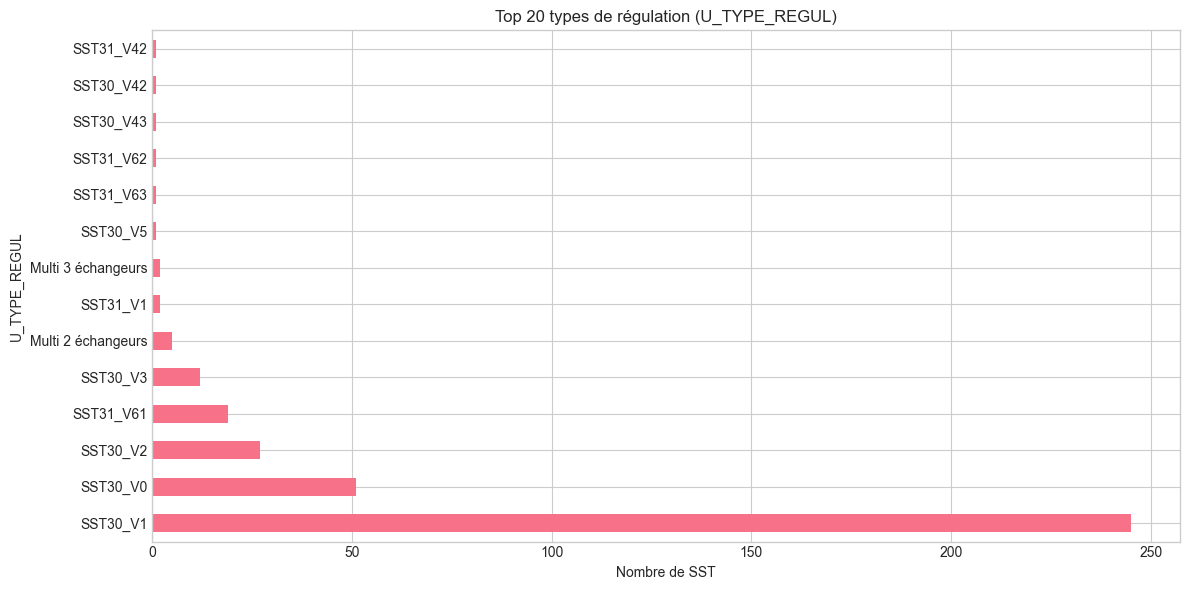

In [6]:
# %% U_TYPE_REGUL
vc_regul = df_sst["U_TYPE_REGUL"].value_counts(dropna=False)
print("Distribution U_TYPE_REGUL :")
print(vc_regul)
print(f"\nValeurs manquantes : {df_sst['U_TYPE_REGUL'].isna().sum()}")
print(f"Types distincts : {df_sst['U_TYPE_REGUL'].nunique()}")

fig, ax = plt.subplots(figsize=(12, 6))
vc_regul.head(20).plot(kind="barh", ax=ax)
ax.set_xlabel("Nombre de SST")
ax.set_title("Top 20 types de régulation (U_TYPE_REGUL)")
plt.tight_layout()
plt.show()

### 2.2 U_PROD_ECS (production ECS)

Distribution U_PROD_ECS :
U_PROD_ECS
1.0    281
0.0     87
NaN      1
Name: count, dtype: int64

Valeurs manquantes : 1


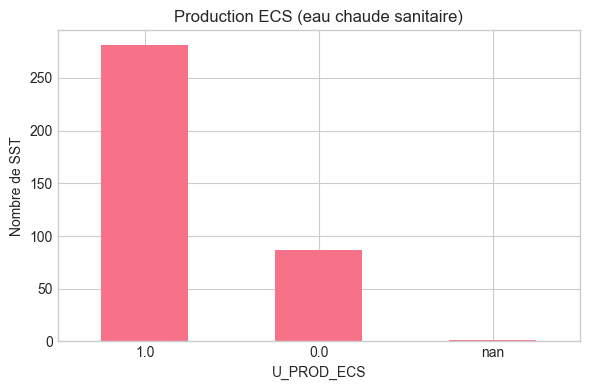

In [7]:
# %% U_PROD_ECS
vc_ecs = df_sst["U_PROD_ECS"].value_counts(dropna=False)
print("Distribution U_PROD_ECS :")
print(vc_ecs)
print(f"\nValeurs manquantes : {df_sst['U_PROD_ECS'].isna().sum()}")

fig, ax = plt.subplots(figsize=(6, 4))
vc_ecs.plot(kind="bar", ax=ax)
ax.set_xticklabels([str(x) for x in vc_ecs.index], rotation=0)
ax.set_xlabel("U_PROD_ECS")
ax.set_ylabel("Nombre de SST")
ax.set_title("Production ECS (eau chaude sanitaire)")
plt.tight_layout()
plt.show()

### 2.3 U_PUISSANCE (puissance nominale en kW)

Statistiques U_PUISSANCE (kW) :
count     369.000000
mean       73.420054
std       130.724589
min         6.000000
25%        11.000000
50%        40.000000
75%        80.000000
max      1400.000000
Name: U_PUISSANCE_kW, dtype: float64

Valeurs manquantes : 0


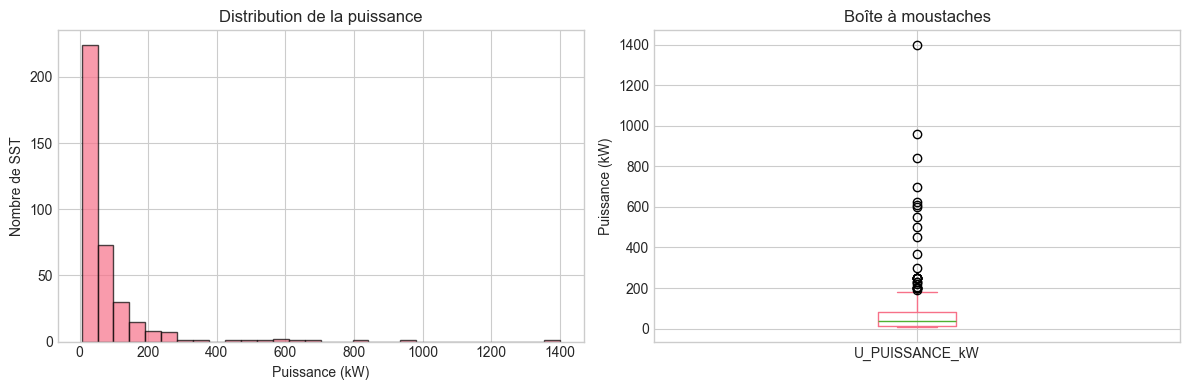

In [8]:
# %% Parsing U_PUISSANCE (format "7kW", "180kW", etc.)
def parse_puissance(s):
    """Extrait la valeur numérique en kW depuis une chaîne comme '7kW' ou '180kW'."""
    if pd.isna(s):
        return np.nan
    m = re.search(r"([\d.]+)\s*k?W", str(s), re.I)
    return float(m.group(1)) if m else np.nan

df_sst["U_PUISSANCE_kW"] = df_sst["U_PUISSANCE"].apply(parse_puissance)
print("Statistiques U_PUISSANCE (kW) :")
print(df_sst["U_PUISSANCE_kW"].describe())
print(f"\nValeurs manquantes : {df_sst['U_PUISSANCE_kW'].isna().sum()}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df_sst["U_PUISSANCE_kW"].hist(bins=30, ax=axes[0], edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Puissance (kW)")
axes[0].set_ylabel("Nombre de SST")
axes[0].set_title("Distribution de la puissance")

df_sst["U_PUISSANCE_kW"].plot(kind="box", ax=axes[1])
axes[1].set_ylabel("Puissance (kW)")
axes[1].set_title("Boîte à moustaches")
plt.tight_layout()
plt.show()

## 3. Préparation des features pour le clustering

Encodage des variables catégorielles et gestion des valeurs manquantes.

In [9]:
# %% Préparation du DataFrame de clustering
df_cluster = df_sst[["U_NO_EGID", "U_TYPE_REGUL", "U_PROD_ECS", "U_PUISSANCE_kW"]].copy()

# Remplacer NaN par une catégorie pour U_TYPE_REGUL et U_PROD_ECS
df_cluster["U_TYPE_REGUL"] = df_cluster["U_TYPE_REGUL"].fillna("_MANQUANT_")
df_cluster["U_PROD_ECS"] = df_cluster["U_PROD_ECS"].fillna(-1).astype(str)  # -1 = manquant

# Encodage U_TYPE_REGUL (LabelEncoder pour KMeans)
le_regul = LabelEncoder()
df_cluster["U_TYPE_REGUL_enc"] = le_regul.fit_transform(df_cluster["U_TYPE_REGUL"].astype(str))

# Encodage U_PROD_ECS (0, 1, -1 pour manquant)
def map_ecs(x):
    s = str(x).strip()
    if s in ("0", "0.0"): return 0
    if s in ("1", "1.0"): return 1
    return -1
df_cluster["U_PROD_ECS_enc"] = df_cluster["U_PROD_ECS"].apply(map_ecs)

# U_PUISSANCE_kW : remplir les manquants par la médiane
med_puissance = df_cluster["U_PUISSANCE_kW"].median()
df_cluster["U_PUISSANCE_kW_fill"] = df_cluster["U_PUISSANCE_kW"].fillna(med_puissance)

# Features pour clustering
features = ["U_TYPE_REGUL_enc", "U_PROD_ECS_enc", "U_PUISSANCE_kW_fill"]
X = df_cluster[features].values

# Normalisation (important pour KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features préparées :", features)
print("Shape X_scaled :", X_scaled.shape)
print("Exemple (5 premières lignes) :")
pd.DataFrame(X_scaled[:5], columns=features)

Features préparées : ['U_TYPE_REGUL_enc', 'U_PROD_ECS_enc', 'U_PUISSANCE_kW_fill']
Shape X_scaled : (369, 3)
Exemple (5 premières lignes) :


,U_TYPE_REGUL_enc,U_PROD_ECS_enc,U_PUISSANCE_kW_fill
0,-0.234086,0.555621,-0.256000
1,-0.234086,-1.748021,-0.485801
2,-0.706096,-1.748021,-0.393881
3,-0.234086,0.555621,-0.493461
4,-0.234086,0.555621,-0.493461


## 4. Clustering KMeans

Choix du nombre de clusters via le score de silhouette.

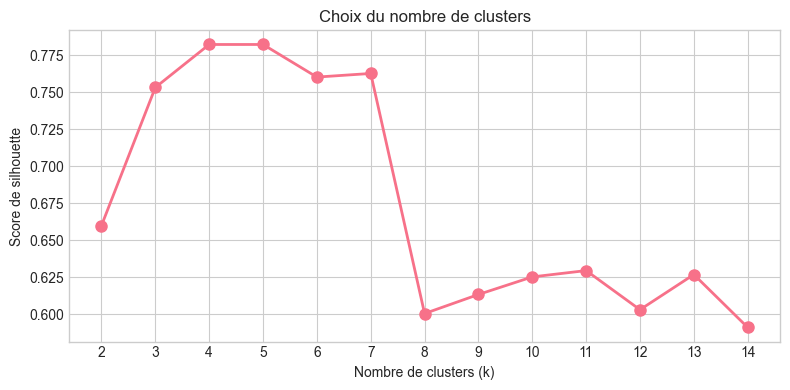

Meilleur k (silhouette max) : 5


In [10]:
# %% Choix du nombre de clusters (silhouette)
k_range = range(2, 15)
silhouette_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(k_range), silhouette_scores, "o-", linewidth=2, markersize=8)
ax.set_xlabel("Nombre de clusters (k)")
ax.set_ylabel("Score de silhouette")
ax.set_title("Choix du nombre de clusters")
ax.set_xticks(list(k_range))
plt.tight_layout()
plt.show()

best_k = list(k_range)[np.argmax(silhouette_scores)]
print(f"Meilleur k (silhouette max) : {best_k}")

In [11]:
# %% Clustering final avec le meilleur k (ou k=6 par défaut)
n_clusters = best_k  # Modifier si besoin (ex. k=6 pour interprétabilité)
km_final = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_cluster["cluster"] = km_final.fit_predict(X_scaled)

print(f"Répartition des {n_clusters} clusters :")
print(df_cluster["cluster"].value_counts().sort_index())

Répartition des 5 clusters :
cluster
0    257
1     24
2     10
3     77
4      1
Name: count, dtype: int64


## 5. Analyse des clusters

Profil de chaque cluster selon U_TYPE_REGUL, U_PROD_ECS et U_PUISSANCE.

In [12]:
# %% Profil des clusters
for c in range(n_clusters):
    subset = df_cluster[df_cluster["cluster"] == c]
    print(f"\n--- Cluster {c} ({len(subset)} SST) ---")
    print("  U_TYPE_REGUL (top 3) :", subset["U_TYPE_REGUL"].value_counts().head(3).to_dict())
    print("  U_PROD_ECS :", subset["U_PROD_ECS"].value_counts().to_dict())
    print("  U_PUISSANCE_kW : min={:.0f}, max={:.0f}, médiane={:.0f}".format(
        subset["U_PUISSANCE_kW"].min(), subset["U_PUISSANCE_kW"].max(), subset["U_PUISSANCE_kW"].median()
    ))


--- Cluster 0 (257 SST) ---
  U_TYPE_REGUL (top 3) : {'SST30_V1': 227, 'SST30_V2': 25, 'SST30_V3': 5}
  U_PROD_ECS : {'1.0': 257}
  U_PUISSANCE_kW : min=7, max=205, médiane=30

--- Cluster 1 (24 SST) ---
  U_TYPE_REGUL (top 3) : {'SST31_V61': 19, 'SST31_V1': 2, 'SST30_V5': 1}
  U_PROD_ECS : {'1.0': 24}
  U_PUISSANCE_kW : min=10, max=100, médiane=10

--- Cluster 2 (10 SST) ---
  U_TYPE_REGUL (top 3) : {'Multi 2 échangeurs': 4, 'SST30_V0': 2, 'Multi 3 échangeurs': 1}
  U_PROD_ECS : {'0.0': 9, '-1.0': 1}
  U_PUISSANCE_kW : min=370, max=960, médiane=605

--- Cluster 3 (77 SST) ---
  U_TYPE_REGUL (top 3) : {'SST30_V0': 49, 'SST30_V1': 18, 'SST30_V3': 7}
  U_PROD_ECS : {'0.0': 77}
  U_PUISSANCE_kW : min=6, max=300, médiane=60

--- Cluster 4 (1 SST) ---
  U_TYPE_REGUL (top 3) : {'Multi 3 échangeurs': 1}
  U_PROD_ECS : {'0.0': 1}
  U_PUISSANCE_kW : min=1400, max=1400, médiane=1400


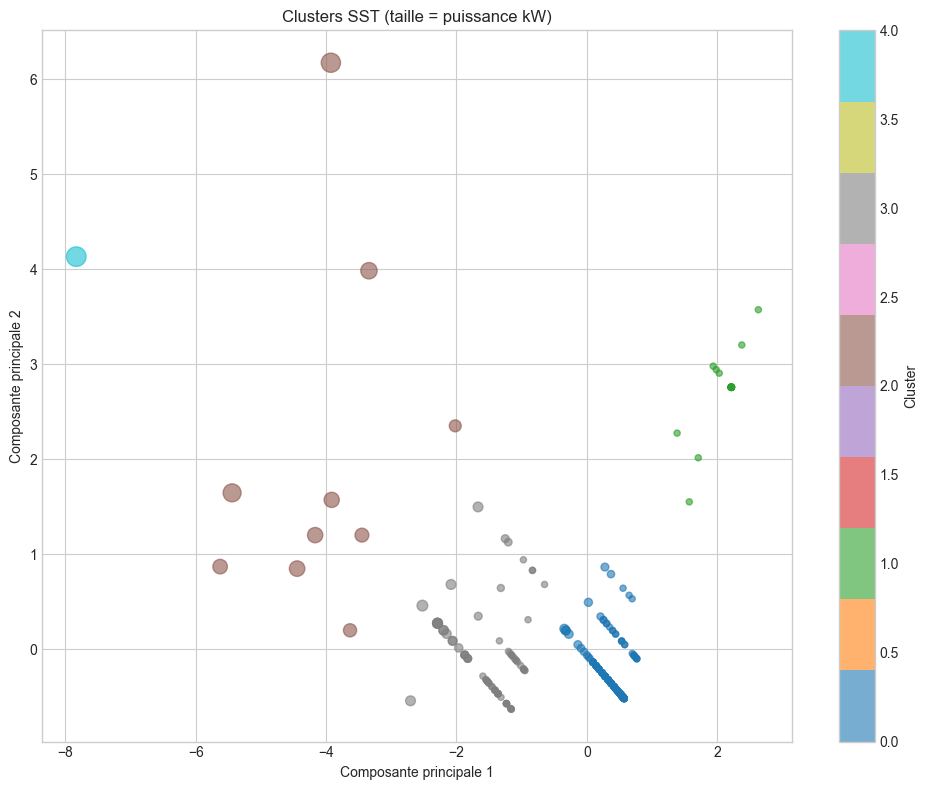

In [13]:
# %% Visualisation 2D (PCA pour réduire en 2D si > 2 features)
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_viz = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "cluster": df_cluster["cluster"],
    "U_PUISSANCE_kW": df_cluster["U_PUISSANCE_kW_fill"],
    "U_TYPE_REGUL": df_cluster["U_TYPE_REGUL"],
})

fig, ax = plt.subplots(figsize=(10, 8))
sizes = np.clip(df_viz["U_PUISSANCE_kW"] / 5, 20, 200)
scatter = ax.scatter(
    df_viz["PC1"], df_viz["PC2"],
    c=df_viz["cluster"], cmap="tab10", alpha=0.6, s=sizes
)
ax.set_xlabel("Composante principale 1")
ax.set_ylabel("Composante principale 2")
ax.set_title("Clusters SST (taille = puissance kW)")
plt.colorbar(scatter, ax=ax, label="Cluster")
plt.tight_layout()
plt.show()

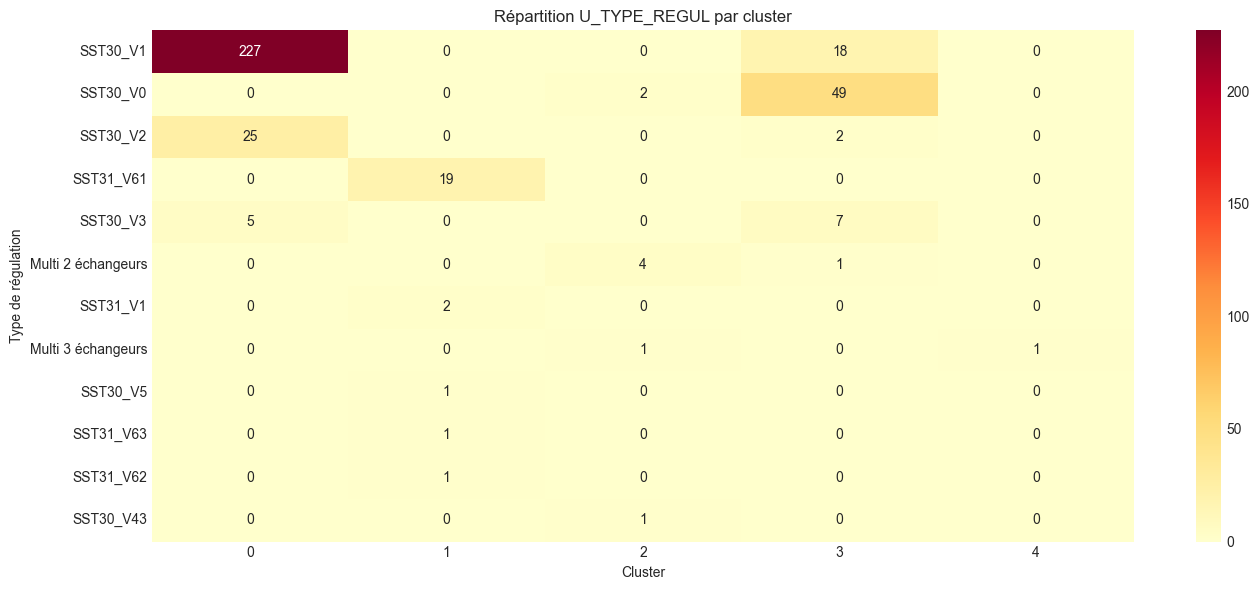

In [14]:
# %% Heatmap : répartition U_TYPE_REGUL par cluster
cross_regul = pd.crosstab(df_cluster["cluster"], df_cluster["U_TYPE_REGUL"])
# Garder les types les plus fréquents pour la lisibilité
top_types = [c for c in df_cluster["U_TYPE_REGUL"].value_counts().head(12).index if c in cross_regul.columns]
cross_regul_top = cross_regul[top_types] if top_types else cross_regul.iloc[:, :12]

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(cross_regul_top.T, annot=True, fmt="d", cmap="YlOrRd", ax=ax)
ax.set_xlabel("Cluster")
ax.set_ylabel("Type de régulation")
ax.set_title("Répartition U_TYPE_REGUL par cluster")
plt.tight_layout()
plt.show()

## 6. Export des résultats

Export du DataFrame enrichi avec les clusters pour réutilisation.

In [ ]:
# %% Export
out_path = Path("0_Data/1_Structured/sst_avec_clusters.parquet")
df_export = df_sst.merge(
    df_cluster[["U_NO_EGID", "cluster"]],
    on="U_NO_EGID",
    how="inner"
)
df_export.to_parquet(out_path, index=False)
print(f"Exporté : {out_path} ({len(df_export)} lignes)")
df_export[["U_NO_EGID", "U_TYPE_REGUL", "U_PROD_ECS", "U_PUISSANCE", "cluster"]].head(10)